In [1]:
import os
import sys
project_path = os.path.expanduser('~/emg2qwerty')
sys.path.append(project_path)

from emg2qwerty.data import EMGSessionData, LabelData, WindowedEMGDataset
import numpy as np
import torch

# First import test data

In [2]:
# Import test data
import yaml
user_name = 'user0'
yaml_path = os.path.expanduser(f'~/emg2qwerty/config/user/{user_name}.yaml')
yaml = yaml.safe_load(open(yaml_path, 'r'))
session_list = yaml['dataset']['test']

# Later, we will need to iterate
# for session in session_list:
#     filename = session['session']
filename = session_list[0]['session'] + '.hdf5'

hdf5_dir = os.path.join(project_path, 'data') 
hdf5_path = os.path.join(hdf5_dir, filename)

# Exploring data class

In [3]:
print(f"Filename: {filename}")

# The EMGSessionData class
data = EMGSessionData(hdf5_path)
print('======= EMGSessionData =======')

item = data.__getitem__(0)  # Get the first sample
print(f"Shape: {item[0].shape}")

length = data.__len__()
print(f"Length: {length}")

GT = data.ground_truth(start_t = 0, end_t = np.inf)
print(f"GT: {(GT.labels.shape)}")

# print(GT.labels) # This labels characters as numbers (axcii)
# print(len(GT.__str__())) # This is the actual alphabet output

timestamp = data.timestamps
timestep = np.diff(timestamp)
print(f"timestamps: {(timestamp.shape)}")
print(f"timestep : {timestep[0:3]} ..., Maximum time in between : {np.max(timestep)}")

keystroke = data.keystrokes
print(f"keystroke: {len(keystroke)}")
print(f"keystroke format : {keystroke[0]}")

# Keystroke and GT have different length <- This was capslock
from collections import Counter
GT_str = list(Counter(GT.__str__()).keys())
keystroke_str = list(Counter([key['key'] for key in keystroke]).keys())
print([key for key in keystroke_str if key not in GT_str])
print(f"Pressed caps lock for {Counter([key['key'] for key in keystroke])['Key.caps_lock']} times")

print(f"Duration : {data.duration_mins * 60}")
print(data.duration_mins * 60, data.timeseries.shape[0] / 2000) # Note that the sampling rate is 2000 Hz)

print('======= WindowedEMGDataset =======')
# The WindowedEMGDataset class
window = WindowedEMGDataset(hdf5_path, window_length=8000, padding=[1800, 200])
print("How many windows? : ", len(window)) # <- 1 window = 4 seconds. so, 926/4 = 231

# widow __getitem__ return emg and labels. labels correspond to the original window
print(window.__getitem__(100)[0].shape, window.__getitem__(100)[1])

Filename: 2020-12-17-1608247041-keystrokes-dca-study@1-e041d7d9-a53b-40f3-aabc-e9714072ca46.hdf5
======= EMGSessionData =======
Shape: (16,)
Length: 2364133
GT: (4722,)
timestamps: (2364133,)
timestep : [0.00049996 0.00049996 0.00049996] ..., Maximum time in between : 0.0005500316619873047
keystroke: 4722
keystroke format : {'ascii': 116, 'key': 't', 'start': 1608247048.857714, 'end': 1608247048.870336}
['Key.space', 'Key.enter', 'Key.backspace']
Pressed caps lock for 0 times
Duration : 1182.0784449577332
1182.0784449577332 1182.0665
======= WindowedEMGDataset =======
How many windows? :  295
torch.Size([10000, 2, 16]) tensor([13,  4, 19, 96,  4, 12, 15, 11, 14, 24,  4,  3, 96], dtype=torch.int32)


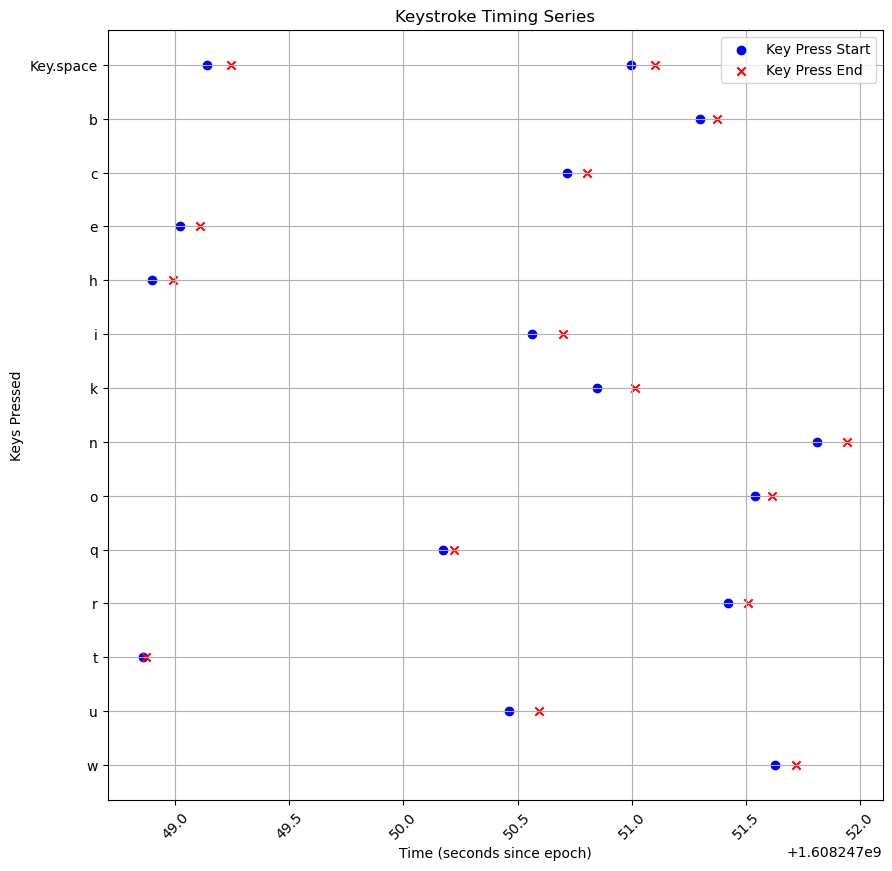

In [4]:
import matplotlib.pyplot as plt
import pandas as pd


# Convert keystroke data into DataFrame
df = pd.DataFrame(keystroke[0:15])
df = df.sort_values(by="key", ascending=False)


# Plot timeseries of keystroke timings
plt.figure(figsize=(10, 10))
plt.scatter(df["start"], df["key"], marker='o', color='b', label="Key Press Start")
plt.scatter(df["end"], df["key"], marker='x', color='r', label="Key Press End")

plt.xlabel("Time (seconds since epoch)")
plt.ylabel("Keys Pressed")
plt.title("Keystroke Timing Series")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Explore Config Files

In [5]:
import yaml

config_path = os.path.expanduser(f'~/emg2qwerty/config/transforms/log_spectrogram.yaml')

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

config['transforms']['test']

'${transforms.val}'

# Perform Inference

In [6]:
# get GT
data = EMGSessionData(hdf5_path)
GT = data.ground_truth(start_t = 0, end_t = np.inf)


# Import the personalized model for the user
from emg2qwerty.lightning import TDSConvCTCModule
model_path = os.path.expanduser(f'~/emg2qwerty/models/personalized-finetuned/{user_name}.ckpt')
model = TDSConvCTCModule.load_from_checkpoint(model_path)
model.eval()

TDSConvCTCModule(
  (model): Sequential(
    (0): SpectrogramNorm(
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MultiBandRotationInvariantMLP(
      (mlps): ModuleList(
        (0-1): 2 x RotationInvariantMLP(
          (mlp): Sequential(
            (0): Linear(in_features=528, out_features=384, bias=True)
            (1): ReLU()
          )
        )
      )
    )
    (2): Flatten(start_dim=2, end_dim=-1)
    (3): TDSConvEncoder(
      (tds_conv_blocks): Sequential(
        (0): TDSConv2dBlock(
          (conv2d): Conv2d(24, 24, kernel_size=(1, 32), stride=(1, 1))
          (relu): ReLU()
          (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): TDSFullyConnectedBlock(
          (fc_block): Sequential(
            (0): Linear(in_features=768, out_features=768, bias=True)
            (1): ReLU()
            (2): Linear(in_features=768, out_features=768, bias=True)
         

In [7]:
# Check if the weights are correctly loaded 
checkpoint = torch.load(model_path, map_location="cpu")
print(checkpoint['state_dict']['model.0.batch_norm.weight'])

for name, param in model.named_parameters():
    print(name, param)  # Print mean and std of weights
    break

# Note the default decoder is CTCGreedyDecoder
checkpoint['hyper_parameters']

tensor([1.0625, 1.1303, 1.1647, 1.2014, 1.2712, 1.2143, 1.2533, 1.0145, 0.9274,
        0.9673, 0.9373, 0.8824, 0.9953, 1.0221, 1.0926, 1.0039, 0.8677, 0.9828,
        1.0272, 1.0369, 1.0571, 1.0568, 1.0566, 0.8051, 0.7075, 0.7387, 0.7736,
        0.7720, 0.8388, 0.8838, 0.9472, 0.8470])
model.0.batch_norm.weight Parameter containing:
tensor([1.0625, 1.1303, 1.1647, 1.2014, 1.2712, 1.2143, 1.2533, 1.0145, 0.9274,
        0.9673, 0.9373, 0.8824, 0.9953, 1.0221, 1.0926, 1.0039, 0.8677, 0.9828,
        1.0272, 1.0369, 1.0571, 1.0568, 1.0566, 0.8051, 0.7075, 0.7387, 0.7736,
        0.7720, 0.8388, 0.8838, 0.9472, 0.8470], requires_grad=True)


{'in_features': 528,
 'mlp_features': [384],
 'block_channels': [24, 24, 24, 24],
 'kernel_width': 32,
 'optimizer': {'_target_': 'torch.optim.Adam', 'lr': 0.001},
 'lr_scheduler': {'scheduler': {'_target_': 'pl_bolts.optimizers.lr_scheduler.LinearWarmupCosineAnnealingLR', 'warmup_epochs': 10, 'max_epochs': '${trainer.max_epochs}', 'warmup_start_lr': 1e-08, 'eta_min': 1e-06}, 'interval': 'epoch'},
 'decoder': {'_target_': 'emg2qwerty.decoder.CTCGreedyDecoder'}}

In [8]:
from emg2qwerty import transforms
# Testing what tranforms do
# Convert the input data into desired shape for the model
to_tensor = transforms.ToTensor()
input = to_tensor.__call__(data)
print("original shape:", input.shape)

transform = transforms.LogSpectrogram()
input_transformed = transform.__call__(input)
print("transformed shape:", input_transformed.shape) # <- T got smaller: 2885776 -> 180358
# Formula : (original - n_fft)/hop_length + 1

original shape: torch.Size([2364133, 2, 16])
transformed shape: torch.Size([147755, 2, 16, 33])


In [ ]:
# Actually, the WindowedEMGDataset will do everything for you
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.LogSpectrogram()])

# Define dataset with the transforms NOTE here, window_length is None, thus it is not windowed.
window_data = WindowedEMGDataset(hdf5_path, window_length=8000, padding=(2000, 0), transform = test_transforms)

print(f'batch :{window_data.__len__()}, input shape: {window_data[0][0].shape}, label shape : {window_data[0][1].shape}')

# DataLoader
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
            window_data,
            batch_size=1,
            shuffle=False,
            num_workers=3,
            collate_fn=window_data.collate,
            pin_memory=True,
            persistent_workers=True)

batch = next(iter(test_dataloader))

del test_dataloader

import gc
gc.collect()
torch.cuda.empty_cache()

pred, loss, metrics = model.test_step(batch)
print(pred[0].__str__())

from emg2qwerty.metrics import CharacterErrorRates
cer = CharacterErrorRates()
cer.update(pred[0], GT)
cer.compute()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

pred, loss, metrics = model.test_step(batch)
print(pred[0].__str__())

from emg2qwerty.metrics import CharacterErrorRates
cer = CharacterErrorRates()
cer.update(pred[0], GT)
cer.compute()

In [ ]:
# Let's test again with CTCBeamDecoder
from emg2qwerty.decoder import CTCBeamDecoder
model.decoder = CTCBeamDecoder()

test_transforms = transforms.Compose([transforms.ToTensor(), transforms.LogSpectrogram()])

# Define dataset with the transforms NOTE here, window_length is None, thus it is not windowed.
window_data = WindowedEMGDataset(hdf5_path, window_length=None, padding=(0, 0), transform = test_transforms)

print(f'batch :{window_data.__len__()}, input shape: {window_data[0][0].shape}, label shape : {window_data[0][1].shape}')

# DataLoader
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
            window_data,
            batch_size=1,
            shuffle=False,
            num_workers=3,
            collate_fn=window_data.collate,
            pin_memory=True, 
            persistent_workers=True)

batch = next(iter(test_dataloader))

del test_dataloader

import gc
gc.collect()
torch.cuda.empty_cache()


pred, loss, metrics = model.test_step(batch)
print(pred[0].__str__())

from emg2qwerty.metrics import CharacterErrorRates
cer = CharacterErrorRates()
cer.update(pred[0], GT)
cer.compute()

batch :1, input shape: torch.Size([147755, 2, 16, 33]), label shape : torch.Size([4722])
the quickk brown fs jumps over a lazy dog
lptira eadwt bhotel wolary
afrli foneacts mississipp⌫ fiew
fasrinating exaiples seekint pringer
friend tyite let
s rest
bane totta⌫⌫⌫⌫⌫⌫⌫g forra lorical entries
impoved ⌫⌫⌫⌫⌫roved trainer undersaneing bire
allowd burton reatured pei⌫⌫ork
monkey tuarantee sunstirute rormed
trailers tlst naures follow
fleri taste tuagge ⌫⌫⌫⌫⌫⌫auge gamuling
mall oassio⌫⌫⌫⌫raiona braue s⌫brev
form torage aorkout hliutiate
pasp lmposed lp⌫mion fomparable
iutlets construc ⌫gt viewing disttribute
anayeim m peer⌫⌫fefers ca⌫⌫easm sport
braz⌫⌫azipiancuts preci⌫fi⌫rid tra spations
incorrectct voting taus vermoent
confterassional sett bup mos.y keremy
protessing ligtersture die⌫⌫e⌫lego impoemented
inestitated yorn⌫⌫⌫⌫mlurmalism happened limitations⌫
ra⌫rancisco ⌫are⌫resting⌫⌫⌫⌫ling rivers couple
bracasting pro⌫⌫ladcasti lg pro
ldals sentence take
mpdified oueo savage alter atives
oess 

/home/kunwoo/anaconda3/envs/emg2qwerty/lib/python3.10/site-packages/pytorch_lightning/core/module.py:377: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


{'CER': 17.36552308343922,
 'IER': 3.5789919525624736,
 'DER': 2.435408725116476,
 'SER': 11.35112240576027}

In [ ]:
print(GT.__str__())

the quick brw⌫ow n⌫⌫n fox jumps over a a⌫ka⌫⌫⌫ lazy dog
adaptation thinks command deer
conflict connect chapel spoke
stunning executin⌫⌫ed brunette terminals
approve turned bracket he
pharmacok⌫logy cove nigeria bored
bodies jumping pursuit sized
diesel losses already pope
corners tuner bunch alternate
estates theories er⌫⌫regional onion
irrigation suitable jeffrey hurricane
criterion columbus efficiency rena⌫⌫markable
prize motorcycles rebates tournaments
bras soit⌫⌫⌫pot moii⌫sture surroundu⌫ing
shannon booty imois⌫⌫⌫pose webcast
dinner duscr⌫⌫⌫⌫iscretion concentrations unfortunately
subscribe agree nu⌫⌫missouri incident
fears rates i⌫cork horrible
ioo⌫⌫⌫opponents spekkun⌫⌫⌫⌫lling describg⌫n⌫ing brokers
directive finally variables grad
stack lifestyle henry reflect
vvu⌫⌫bulletin insert colors onto
actos ⌫⌫rs reservations co⌫roatia winning
rack identified directories receiving
subru⌫⌫urban manitoba gateway smoking
hae⌫te crush but⌫yg⌫er groove
subsa⌫tat⌫ntially wrap relates my
comfort 